### LSTM - Crude Oil Price Prediction

Here we import data from fred of timeseries based crude oil prices.
we then try and apply an LSTM and build a model on the same using the training set of the data

In [25]:
# The code was removed by DSX for sharing.

,DATE,DCOILBRENTEU
0,2013-04-16,97.88
1,2013-04-17,96.84
2,2013-04-18,97.48
3,2013-04-19,98.94
4,2013-04-22,99.07



#### Data Source

U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [26]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print df_data_1.shape

(1273, 2)


In [27]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.iloc[:,1:2].values
df_data_1_plot

array([['97.88'],
       ['96.84'],
       ['97.48'],
       ...,
       ['72.74'],
       ['71.44'],
       ['73.18']], dtype=object)

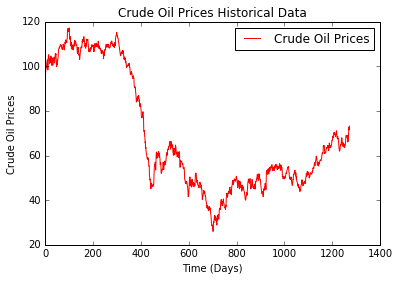

In [28]:
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

### Stateful vs. Stateless LSTM

#### Stateless: 
LSTM updates parameters on batch 1 and then initiates cell states (meaning - memory, usually with zeros) for batch 2
#### Stateful: 
it uses batch 1 last output cell sates as initial states for batch 2.

#### When to use which?

When sequences in batches are related to each other (e.g. prices of one commodity), we should better use stateful mode
Else, when one sequence represents a complete sentence, we should go with stateless mode

#### Batch-size: which batch-size to choose?

Very important decision!

Imagine, you must learn to recognize a bird... You are presented images of different birds.

What would you prefer:

To see the one image at a time, make your notes about special bird quilities (set your weights) and then see another bird and so on
OR may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?
I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish.

##### So the machines! Therefore we select a batch size of 64. Later in programming assigment we will see how the batch size impacts the prediction accuracy.

In [29]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

In [30]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

### Batch-size and trainings-set size

With stateful LSTMs the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [31]:
length = len(df_data_1)
print length
length *= 1 - 0.1
print length

1273
1145.7


In [32]:
1145.7%64.0

57.700000000000045

In [33]:
1273%64.0

57.0

In [34]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print x
    return (max(train_length_values))

In [35]:
length = get_train_length(df_data_1, batch_size, 0.1)
print length

1088
1088


In [36]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(1148, 1)

In [37]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(1148, 1)

In [38]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print length + timesteps
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print len(X_train)
print len (y_train)
print np.array(X_train).shape
print np.array(y_train).shape

1118
1088
1088
(1088, 30)
(1088, 30)


In [39]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print X_train.shape
print y_train.shape

(1088, 30, 1)
(1088, 30, 1)


In [40]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [41]:
!pip install h5py

In [42]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [43]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps, 1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)  # dense is a fully connected layer; unit is the o/p channel

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


#### Observe the LSTM layer summary above

In [44]:
# Rerunning with 20 units in the LSTM


inputs_1_mae = Input(batch_shape=(batch_size,timesteps, 1))
lstm_1_mae = LSTM(20, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(20, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)  # dense is a fully connected layer; unit is the o/p channel

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 30, 20)              1760      
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 20)              3280      
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


#### Observe the LSTM layer summary above

In [45]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

### Citation from Redwood Center for Theoretical Neuroscince (Berkeley University)
http://redwood.berkeley.edu

http://redwood.berkeley.edu/vs265/Brian-Cheung-LSTMS.pdf

### Overall LSTM Structure

Screen%20Shot%202018-01-13%20at%2013.40.12.png

### LSTM Node Anatomy
Screen%20Shot%202018-01-13%20at%2013.26.12.png

### One of the best articles:
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### How LSTM Param Number is computed?
To decide how to handle the memory each LSTM Cell has :
input (what to let in),
forget (what to forget) and
output (what to write to the output)
LSTM Cell State is its memory
LSTM Hidden State is equivalent to the Cell output:
lstm_hidden_state_size (number of neurons = memory cells) = lstm_outputs_size
Parameters:
weights for the inputs (lstm_inputs_size)
weights for the outputs (lstm_outputs_size)
bias variable
Result from previous point - for all 3 Gates and for Cell State ( = 4)

\begin{equation}

  \textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
\end{equation}